In [1]:
%load_ext autoreload
%autoreload 2
import os
from encoding_information.gpu_utils import limit_gpu_memory_growth  
limit_gpu_memory_growth()
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

from resolution1d_utils import *
from tqdm import tqdm

Rayleigh distance: 400.0 nm


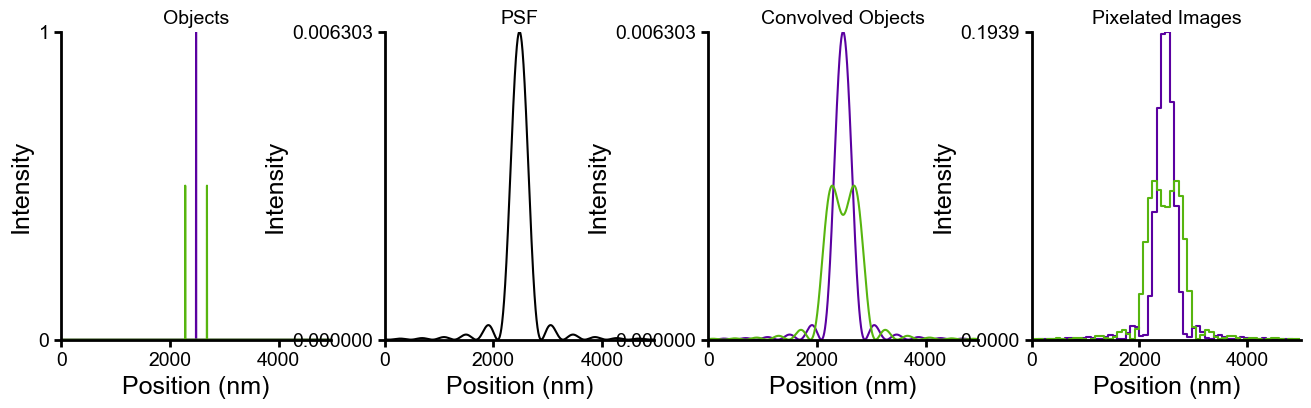

In [8]:
wavelength = 400 # nm
NA = .5
pixel_size = 80 # nm
size = 5000 # nm
num_pixels = int(size / pixel_size)
# seperation_distance = 400 # nm

rayleigh_dist = wavelength / (2 * 0.5)
seperation_distance = rayleigh_dist
print(f"Rayleigh distance: {rayleigh_dist} nm")

(one_point_object, two_point_object, one_point_convolved, two_point_convolved, one_point_noiseless_pixels, two_point_noiseless_pixels,
  x, PSF) = simulate_optics(wavelength, NA, size, seperation_distance, pixel_size)


###### Make plots ###### 
# plot both objects
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].plot(x, one_point_object, get_color_cycle()[1])
ax[0].plot(x, two_point_object, get_color_cycle()[3])
ax[0].set(title='Objects', xlim=(x.min(), x.max()), ylim=(0, 1), yticks=[0, 1], xlabel='Position (nm)', ylabel='Intensity')

# plot the PSF
ax[1].plot(x, PSF, 'k-')
ax[1].set(title='PSF', xlim=(x.min(), x.max()), ylim=(0, PSF.max()), yticks=[0, PSF.max()], xlabel='Position (nm)', ylabel='Intensity')

# plot the convolved objects
ax[2].plot(x, one_point_convolved, get_color_cycle()[1])
ax[2].plot(x, two_point_convolved, get_color_cycle()[3])
ax[2].set(title='Convolved Objects', xlim=(x.min(), x.max()), ylim=(0, one_point_convolved.max()), 
          yticks=[0, one_point_convolved.max()], xlabel='Position (nm)', ylabel='Intensity')


# plot pixelated images
ax[3].plot(np.linspace(0, num_pixels * pixel_size, num_pixels), one_point_noiseless_pixels, drawstyle='steps-mid', color=get_color_cycle()[1])
ax[3].plot(np.linspace(0, num_pixels * pixel_size, num_pixels), two_point_noiseless_pixels, drawstyle='steps-mid', color=get_color_cycle()[3])
ax[3].set(title='Pixelated Images', xlim=(0, size), ylim=(0, one_point_noiseless_pixels.max()), 
          yticks=[0, one_point_noiseless_pixels.max()], xlabel='Position (nm)', ylabel='Intensity')

_ = [clear_spines(ax[i]) for i in range(len(ax))]

# Estimate the MI of noisy measurements

Text(0.5, 0.98, 'SNR: 1, MI: 1.0005 bits')

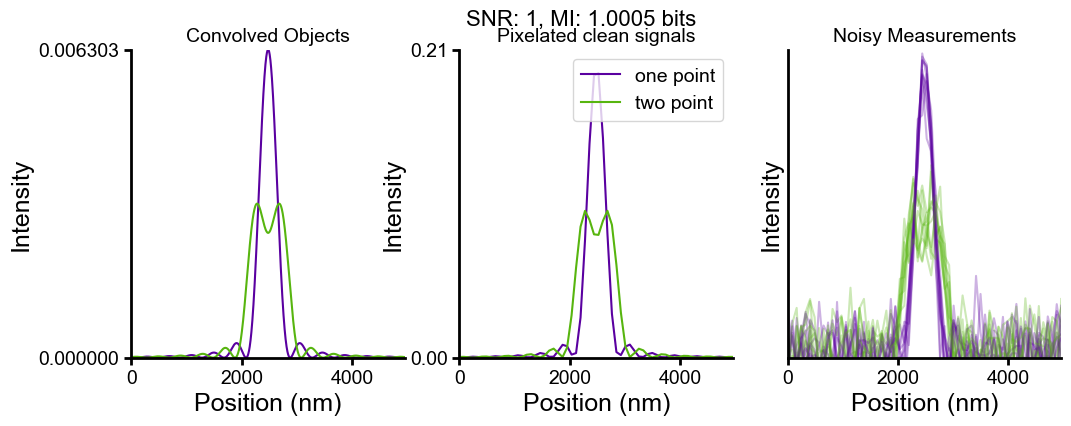

In [3]:
num_measurements = int(1e6)
snr = 1
num_measurements_to_display = 10

mi = estimate_2_point_1_point_mi(one_point_noiseless_pixels, two_point_noiseless_pixels, snr=snr, num_measurements=num_measurements)

make_signal_and_measurement_plot(one_point_convolved, two_point_convolved, one_point_noiseless_pixels, two_point_noiseless_pixels, x, snr, 
                                 alpha=0.3, num_measurements=num_measurements_to_display, show_pixelated=False)
plt.gcf().suptitle(f'SNR: {snr}, MI: {mi:.4f} bits', fontsize=16)

### Sample size vs estimate
How big of samples are needed to get accurate results

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Estimated MI: 0.999 bits


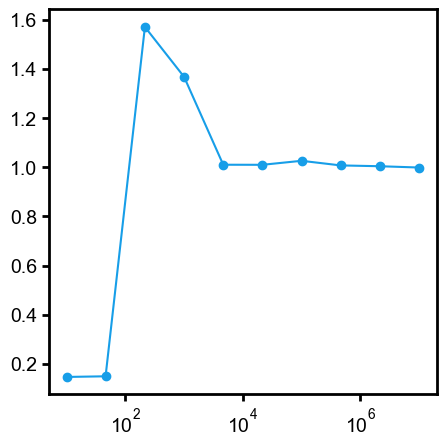

In [9]:
# Look at sample size dependence of estimate
nums_to_use = np.logspace(1, 7, 10, base=10).astype(int)
mis = []

for num_to_use in tqdm(nums_to_use):
    mi = estimate_2_point_1_point_mi(one_point_noiseless_pixels, two_point_noiseless_pixels, snr, num_measurements=num_to_use)
    mis.append(mi)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.semilogx(nums_to_use, mis, 'o-')

print(f"Estimated MI: {mi:.3f} bits")

## Do Information vs SNR and NA



In [39]:
# SNRs = np.linspace(2, 0.1, 20)
SNRs = np.logspace(-2, 1, 40)
NAs = np.linspace(0.1, 1, 40) 

num_measurements = int(5e5)

wavelength = 400 # nm
pixel_size = 80 # nm
size = 5000 # nm
num_pixels = int(size / pixel_size)
seperation_distance =  wavelength / (2 * 0.5) # rayleigh distance for NA = 0.5


results = onp.zeros((len(SNRs), len(NAs)))
for i, snr in tqdm(enumerate(SNRs), total=len(SNRs)):
    for j, na in enumerate(NAs):
        (one_point_object, two_point_object, one_point_convolved, two_point_convolved, one_point_noiseless_pixels, two_point_noiseless_pixels,
          x, PSF) = simulate_optics(wavelength, na, size, seperation_distance, pixel_size=pixel_size)
        mi = estimate_2_point_1_point_mi(one_point_noiseless_pixels, two_point_noiseless_pixels, snr, num_measurements=num_measurements)
        results[i, j] = mi

results = np.array(results)

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [09:02<00:00, 13.57s/it]


KeyboardInterrupt: 

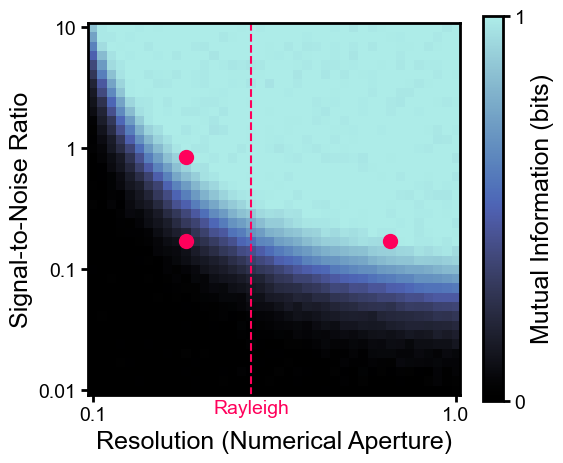

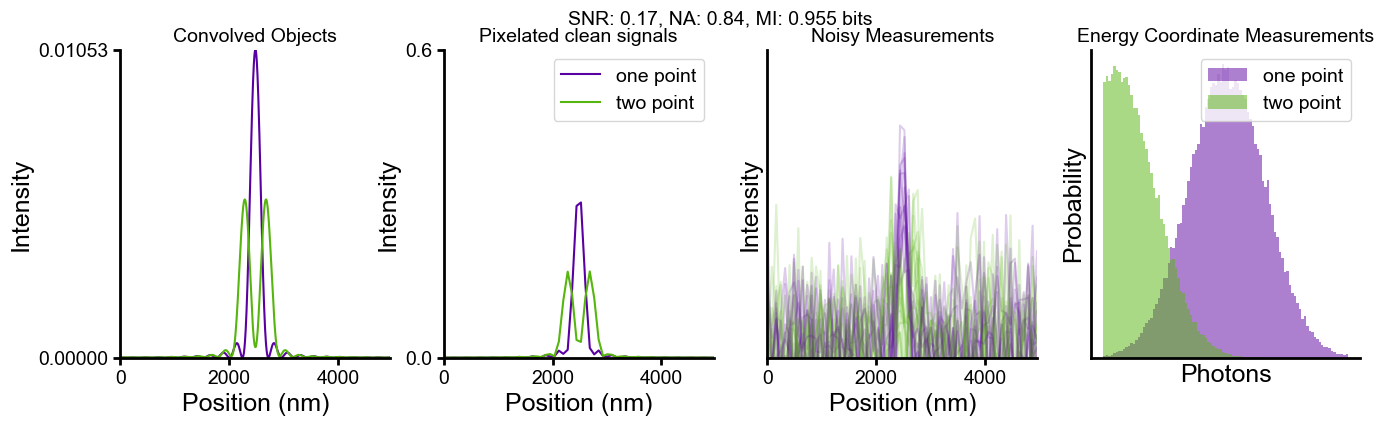

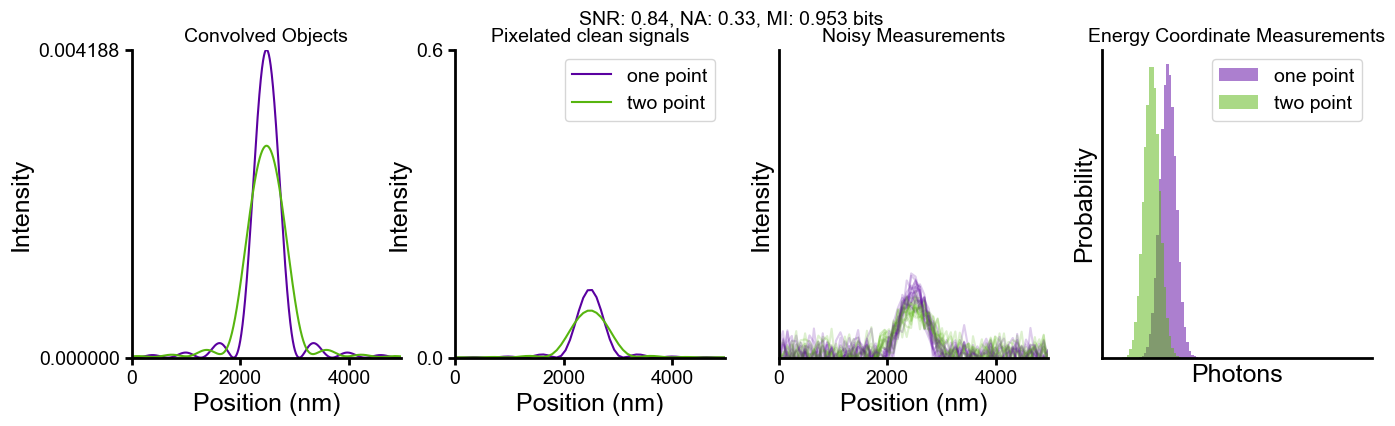

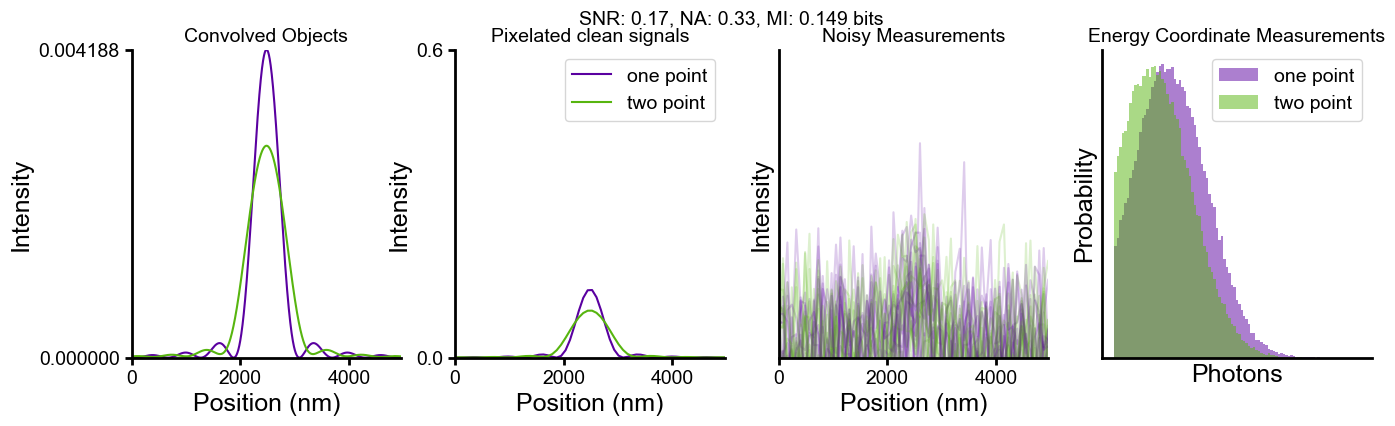

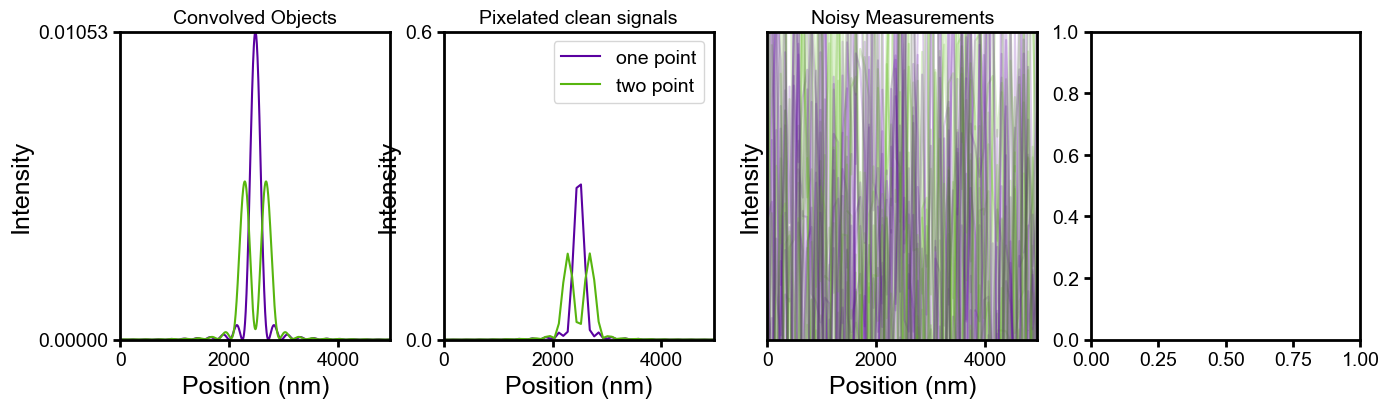

In [58]:
show_pixelated = False
num_noisy_measurements_to_display = 14
alpha = 0.2


num_distribution_measurements = 100000
y_max = 0.6
project_to_optimal = False


import cmasher as cmr
from matplotlib.ticker import LogLocator, LogFormatter

cmap = cmr.sapphire
red = get_color_cycle()[2]

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
cax = ax.imshow(results, cmap=cmap, origin='lower', vmin=0, vmax=1,)
            #      extent=[NAs[0], NAs[-1], SNRs[0], SNRs[-1]],
            # aspect= (NAs[-1] - NAs[0]) / (SNRs[-1] - SNRs[0]))
cbar = fig.colorbar(cax, ax=ax)
cbar.set_label('Mutual Information (bits)')
# set color bar labels to 0, 1
cbar.set_ticks([0, 1])

# make a ytick for every power of 10 in SNRs
ytick_labels = [ str(10**i) for i in range(int(np.log10(SNRs[0])), int(np.log10(SNRs[-1])) + 1)]

_ = ax.set(xlabel='Resolution (Numerical Aperture)', ylabel='Signal-to-Noise Ratio',
        xticks=[0, len(NAs) - 1], xticklabels=[NAs[0], NAs[-1]],
        yticks= np.linspace(0, len(SNRs) - 1, len(ytick_labels)), yticklabels=ytick_labels)


def add_point(SNR_value, NA_value):
        # Find the indices from the values, this is necessary for simulation and result extraction
        SNR_index = np.argmin(np.abs(SNRs - SNR_value))
        NA_index = np.argmin(np.abs(NAs - NA_value))

        # now replace the values with the ones we have data for
        SNR_value = SNRs[SNR_index]
        NA_value = NAs[NA_index]

        # Retrieve simulation details using indices if necessary
        (one_point_object, two_point_object, one_point_convolved, two_point_convolved, 
        one_point_noiseless_pixels, two_point_noiseless_pixels, x, PSF) = simulate_optics(wavelength, NA_value, size,
                                                                                        seperation_distance, pixel_size)
        
        make_signal_and_measurement_plot(one_point_convolved, two_point_convolved, one_point_noiseless_pixels, 
                                        two_point_noiseless_pixels, x, SNR_value,
                                        show_pixelated=show_pixelated, num_measurements=num_noisy_measurements_to_display, alpha=alpha,
                                        energy_coord_measurements=num_distribution_measurements, y_max=y_max, projection_vector=project_to_optimal)
                                        

        plt.gcf().suptitle(f"SNR: {SNR_value:.2f}, NA: {NA_value:.2f}, MI: {results[SNR_index, NA_index]:.3f} bits", fontsize=14)

        # Plot the point using the actual SNR and NA values
        ax.plot(NA_index, SNR_index, 'o', markersize=10, color=red)
        return results[SNR_index, NA_index]


def find_point_within_limits(mi_limits, na_limits):
        NA_grid, SNR_grid = np.meshgrid(NAs, SNRs)

        search_space = results.copy()
        
        if na_limits[0] is not None:
                search_space[NA_grid < na_limits[0]] = np.nan
        if na_limits[1] is not None:
                search_space[NA_grid > na_limits[1]] = np.nan
        
        if mi_limits[0] is not None:
                search_space[results < mi_limits[0]] = np.nan
        if mi_limits[1] is not None:
                search_space[results > mi_limits[1]] = np.nan

        # find the lowest SNR combo that meets the criteria
        SNR_grid[np.isnan(search_space)] = np.nan
        max_index = np.nanargmin(SNR_grid)
        max_index = np.unravel_index(max_index, search_space.shape)
        mi = add_point(SNR_value=SNRs[max_index[0]], NA_value=NAs[max_index[1]])
        return SNRs[max_index[0]], NAs[max_index[1]], mi


# compute NA that gives the Rayleigh distance for this seperation distance
rayleigh_na = wavelength / (2 * seperation_distance)
# make a dotted line at the Rayleigh NA
ax.axvline(np.argmin(np.abs(NAs - rayleigh_na)), color=red, linestyle='--')
# add label on the x axis
ax.text(np.argmin(np.abs(NAs - rayleigh_na)), -1, f'Rayleigh', color=red, ha='center', va='top')



### Find points to plot


snr1, na1, mi1 = find_point_within_limits(mi_limits=(0.95, 1), na_limits=(0.8, .9))
plt.gcf().savefig('/home/hpinkard_waller/figures/1d_signals/' + f'2_point_representative_signals_1' + '.pdf', transparent=True)

snr2, na2, mi2 = find_point_within_limits(mi_limits=(0.95, 1), na_limits=(0.25, 0.35))
plt.gcf().savefig('/home/hpinkard_waller/figures/1d_signals/' + f'2_point_representative_signals_2' + '.pdf', transparent=True)

mi3 = add_point(snr1, na2)
plt.gcf().savefig('/home/hpinkard_waller/figures/1d_signals/' + f'2_point_representative_signals_3' + '.pdf', transparent=True)

find_point_within_limits(mi_limits=(mi3 - .03, mi3 + 0.03), na_limits=(na1 - 0.02, na1 + 0.02))
plt.gcf().savefig('/home/hpinkard_waller/figures/1d_signals/' + f'2_point_representative_signals_4' + '.pdf', transparent=True)

fig.savefig('/home/hpinkard_waller/figures/1d_signals/' + f'2_point_snr_resolution_info' + '.pdf', transparent=True)


In [ ]:
# make an intensity coord plot for the center pixel and centered on one of the other two peaks



## Plot optimal classifier performance vs information

In [ ]:
def get_info_and_best_classifier(num_dimesnions, sigma, mean_difference):
    """
    Assuming additive white Gaussian noise, both the informaiton content and the best classifier are known
    """
    normalized_difference = mean_difference / sigma